# Assignment 1: Anomaly detection through LSTM

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Dataset description (columns name and correspondent descriptions):
1. **Time**: Time of measurement, given in following format: yyyy-mm-dd HH:MM:SS.
2. **Tp**: The temperature of the water, given in °C.
3. **Cl**: Amount of chlorine dioxide in the water, given in mg/L (MS1).
4. **pH**: PH value of the water.
5. **Redox**: Redox potential, given in mV.
6. **Leit**: Electric conductivity of the water, given in µS/cm.
7. **Trueb**: Turbidity of the water, given in NTU.
8. **Cl_2**: Amount of chlorine dioxide in the water, given in mg/L ($MS_2$).
9. **Fm**: Flow rate at water line 1, given in $m^3$/h.
10. **Fm_2**: Flow rate at water line 2, given in $m^3$/h.
11. **EVENT**: Marker if this entry should be considered as a remarkable change resp. event, given in boolean.

Note1: Data goes **from August 2016 to November 2016**.

Note2: The column EVENT contains the changes registered in water quality. These changes will be detected using LSTM architecture, and the column EVENT will be used at the end for a final check.

## Loading of the dataset

In [2]:
#File path
path = r"C:\Users\sofyc\OneDrive\Desktop\UPEC\ML II\project LSTM\ResourcePackage2018\ResourcePackage\source\R\Framework\Data\waterDataTraining.RDS"

#Loading
data = pyreadr.read_r(path) #dictionary

data

OrderedDict([(None,
                                    Time    Tp    Cl    pH  Redox   Leit  Trueb   Cl_2  \
              0      2016-08-03 09:49:00   6.5  0.17  8.36  749.0  211.0  0.011  0.118   
              1      2016-08-03 09:50:00   6.5  0.17  8.36  749.0  211.0  0.011  0.118   
              2      2016-08-03 09:51:00   6.5  0.17  8.35  749.0  211.0  0.011  0.117   
              3      2016-08-03 09:52:00   6.5  0.17  8.35  749.0  211.0  0.011  0.118   
              4      2016-08-03 09:53:00   6.5  0.17  8.35  749.0  211.0  0.011  0.118   
              ...                    ...   ...   ...   ...    ...    ...    ...    ...   
              139561 2016-11-08 07:50:00  10.1  0.16  8.41  762.0  189.0  0.023  0.105   
              139562 2016-11-08 07:51:00  10.1  0.17  8.41  762.0  190.0  0.022  0.106   
              139563 2016-11-08 07:52:00  10.1  0.17  8.41  762.0  190.0  0.022  0.106   
              139564 2016-11-08 07:53:00  10.1  0.17  8.41  762.0  190.0  0.022 

In [3]:
#Extracting the object from the dictionary data
df = data[None]  #RDS file format usually saves a single anonimous object

#Take a look
df

,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,2016-08-03 09:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2016-08-03 09:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,2016-08-03 09:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,2016-08-03 09:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,2016-08-03 09:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False
...,...,...,...,...,...,...,...,...,...,...,...
139561,2016-11-08 07:50:00,10.1,0.16,8.41,762.0,189.0,0.023,0.105,1799.0,924.0,False
139562,2016-11-08 07:51:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1835.0,927.0,False
139563,2016-11-08 07:52:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1807.0,924.0,False
139564,2016-11-08 07:53:00,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1799.0,930.0,False


In [4]:
#Number of anomalies
sum(df['EVENT']==True)

1726

## Exploratory data analysis
- ##### Descriptive Statistics for each interested variable.

In [5]:
#Columns names
columns = ['Time', 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']

for i in columns[2:]:
    display(pd.DataFrame(df[i].describe()).transpose())

,count,mean,std,min,25%,50%,75%,max
Cl,138521.0,0.165482,0.010207,0.0,0.16,0.17,0.17,0.8


,count,mean,std,min,25%,50%,75%,max
pH,138522.0,8.366416,0.101624,4.0,8.34,8.37,8.39,8.936228


,count,mean,std,min,25%,50%,75%,max
Redox,138522.0,752.899009,12.945284,300.0,751.0,754.0,756.0,895.0


,count,mean,std,min,25%,50%,75%,max
Leit,138522.0,209.520998,7.747497,0.0,209.0,211.0,211.0,646.0


,count,mean,std,min,25%,50%,75%,max
Trueb,138522.0,0.019778,0.005492,0.0,0.016,0.018,0.023,0.254


,count,mean,std,min,25%,50%,75%,max
Cl_2,138522.0,0.106099,0.007132,0.0,0.103,0.106,0.11,0.462


,count,mean,std,min,25%,50%,75%,max
Fm,138522.0,1534.208891,208.171011,0.0,1388.0,1512.0,1650.0,3923.0


,count,mean,std,min,25%,50%,75%,max
Fm_2,138522.0,927.728014,147.44743,0.0,847.0,925.0,1000.0,2592.0


- ##### Time series plot for each variable. 'Time' and 'EVENT' are excluded. Anomalies from the column 'EVENT' are signed by red points.

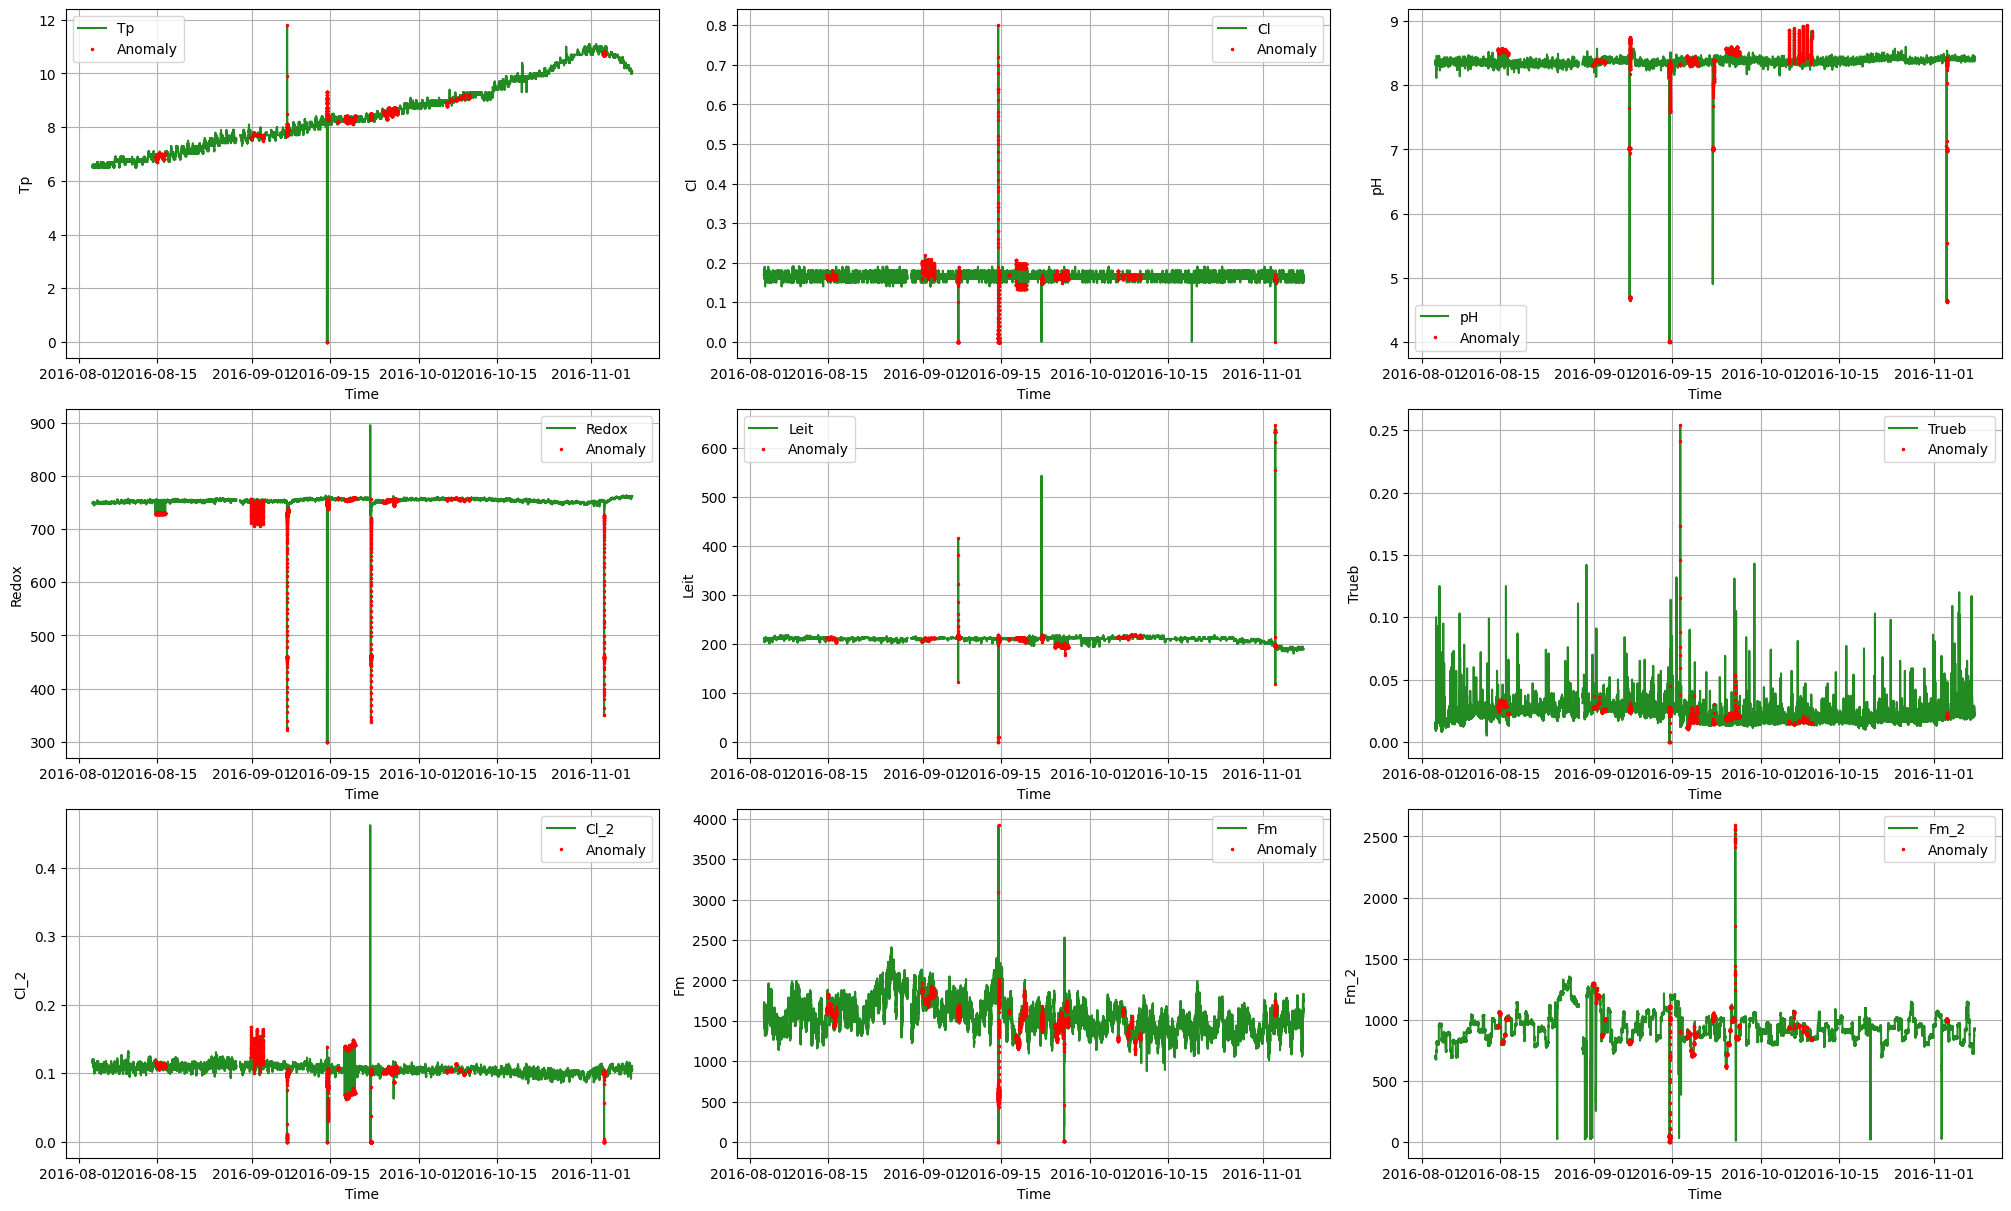

In [6]:
#Number of subplots excluding 'Time'
num_cols = len(columns) - 1
rows = (num_cols + 2) // 3  #3 subplots per row

fig, axes = plt.subplots(rows, 3, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(columns[1:]):  #Excluding the column 'Time'
    ax = axes[i]
    
    #Time series of the specific variable
    ax.plot(df['Time'], df[col], label=col, color='forestgreen')
    
    #Anomalies where 'EVENT'=True
    anomaly_mask = df['EVENT'] == True
    ax.plot(df['Time'][anomaly_mask], df[col][anomaly_mask], '.', label='Anomaly', color='red', markersize=3)
    
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.grid(True)
    ax.legend()
plt.show()


- ##### Seasonality plots.

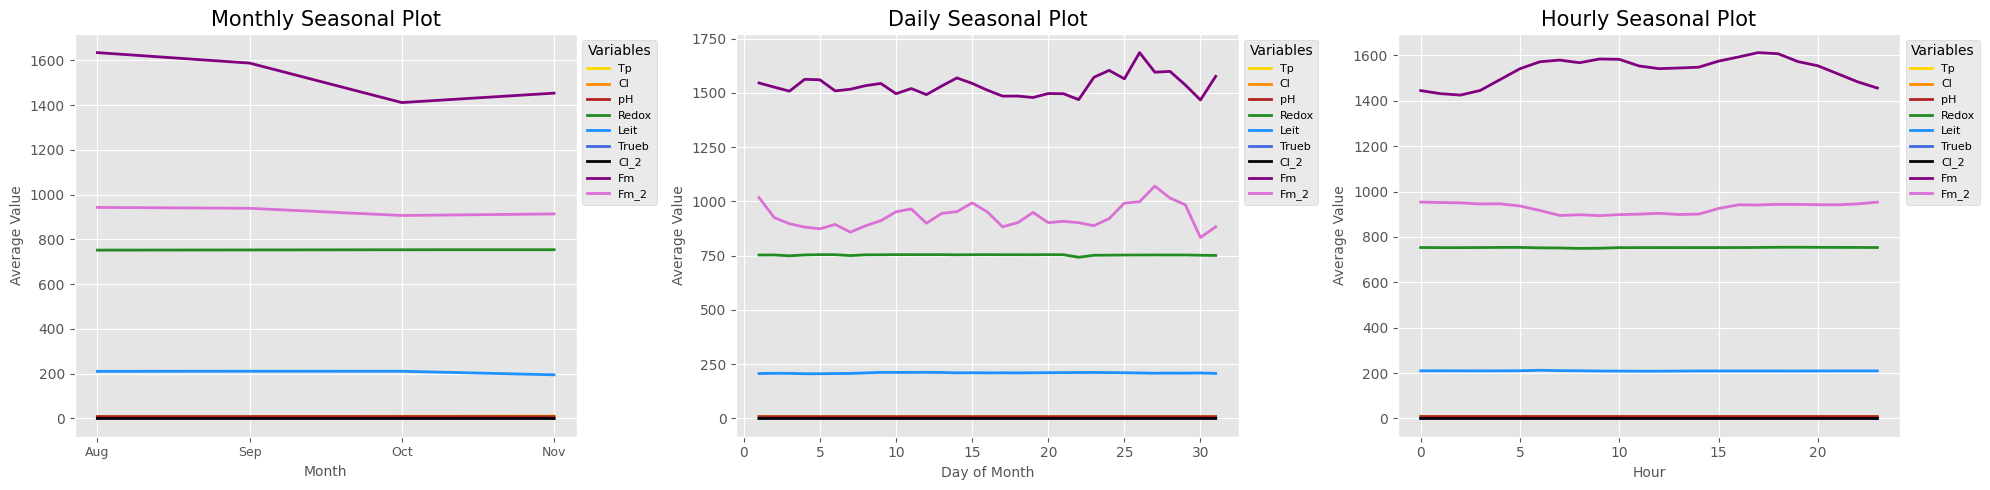

In [7]:
#Just an initial checkl for the datetime format
df['Time'] = pd.to_datetime(df['Time'])

#Extracting the year, month, the day and the hour.
df.loc[:, 'year'] = df['Time'].dt.year
df.loc[:, 'month'] = df['Time'].dt.month
df.loc[:, 'day'] = df['Time'].dt.day
df.loc[:, 'hour'] = df['Time'].dt.hour

#Columns to plot
columns = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']

#Groupifying data by month
df_plot_monthly = (
    df.groupby(['month'])[columns].mean()
    .reset_index()
    .sort_values(by='month')
)

#Groupifying data by day
df.loc[:, 'day_of_month'] = df['Time'].dt.day
df_plot_daily = (
    df.groupby(['day_of_month'])[columns].mean()
    .reset_index()
    .sort_values(by='day_of_month')
)

#Groupifying data by hour
df_plot_hourly = (
    df.groupby(['hour'])[columns].mean()
    .reset_index()
    .sort_values(by='hour')
)

#Plot settings
color = ['gold', 'darkorange', 'firebrick', 'forestgreen', 'dodgerblue', 
         'royalblue', 'black', 'purple', 'orchid'] #Colors
plt.style.use('ggplot') #Style

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#Plot for monthly seasonality
for i, col in enumerate(columns):
    axes[0].plot(df_plot_monthly['month'], df_plot_monthly[col], 
                 label=col, color=color[i], linewidth=2)
axes[0].set_title('Monthly Seasonal Plot', fontsize=15)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('Average Value', fontsize=10)
axes[0].set_xticks([8, 9, 10, 11])
axes[0].set_xticklabels(['Aug', 'Sep', 'Oct', 'Nov'], fontsize=9)
axes[0].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

#Plot for daily seasonality
for i, col in enumerate(columns):
    axes[1].plot(df_plot_daily['day_of_month'], df_plot_daily[col], 
                 label=col, color=color[i], linewidth=2)
axes[1].set_title('Daily Seasonal Plot', fontsize=15)
axes[1].set_xlabel('Day of Month', fontsize=10)
axes[1].set_ylabel('Average Value', fontsize=10)
axes[1].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

#Plot for hourly seasonality
for i, col in enumerate(columns):
    axes[2].plot(df_plot_hourly['hour'], df_plot_hourly[col], 
                 label=col, color=color[i], linewidth=2)
axes[2].set_title('Hourly Seasonal Plot', fontsize=15)
axes[2].set_xlabel('Hour', fontsize=10)
axes[2].set_ylabel('Average Value', fontsize=10)
axes[2].legend(title='Variables', fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## LSTM architecture

In [ ]:
print(df['Time'])
#Data are registered each minut

0        2016-08-03 09:49:00
1        2016-08-03 09:50:00
2        2016-08-03 09:51:00
3        2016-08-03 09:52:00
4        2016-08-03 09:53:00
                 ...        
139561   2016-11-08 07:50:00
139562   2016-11-08 07:51:00
139563   2016-11-08 07:52:00
139564   2016-11-08 07:53:00
139565   2016-11-08 07:54:00
Name: Time, Length: 139566, dtype: datetime64[ns]


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Filtrare le colonne rilevanti
columns = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']
data = df[columns]

# Normalizzazione dei dati (tra 0 e 1 per la rete LSTM)
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Creare sequenze per LSTM
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

timesteps = 60  #Cattura fluttuazioni su una scala temporale di un'ora.
sequences = create_sequences(data_normalized, timesteps)

# Dividi i dati in training e test
train_size = int(0.8 * len(sequences))  # 80% per il training
X_train = sequences[:train_size]
X_test = sequences[train_size:]


c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\sklearn\preprocessing\_data.py:542: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_


c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 9)          │         1,161 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,065 (988.54 KB)

 Trainable params: 253,065 (988.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 485s 150ms/step - loss: nan - val_loss: nan
Epoch 2/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 497s 158ms/step - loss: nan - val_loss: nan
Epoch 3/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 483s 154ms/step - loss: nan - val_loss: nan
Epoch 4/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 481s 153ms/step - loss: nan - val_loss: nan
Epoch 5/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 491s 156ms/step - loss: nan - val_loss: nan
Epoch 6/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 502s 160ms/step - loss: nan - val_loss: nan
Epoch 7/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 516s 164ms/step - loss: nan - val_loss: nan
Epoch 8/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 513s 163ms/step - loss: nan - val_loss: nan
Epoch 9/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 521s 166ms/step - loss: nan - val_loss: nan
Epoch 10/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 523s 167ms/step - loss: nan - val_loss: nan
Epoch 11/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 520s 166ms/step - loss: nan - val_loss: nan
Epoch 12/50
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 519s 165m

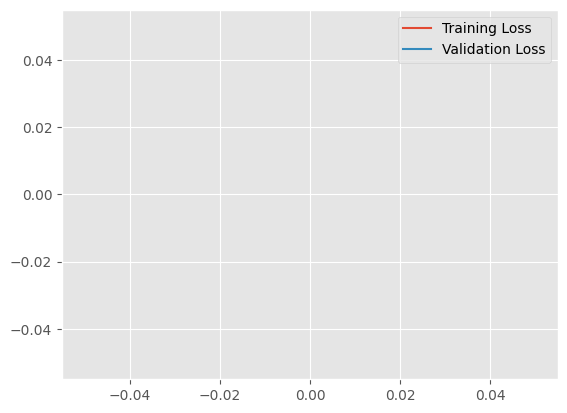

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Definizione dell'Autoencoder LSTM
model = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, X_train.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Addestramento
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, shuffle=False)

# Tracciare la perdita durante l'addestramento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [13]:
# Predizione sul set di test
reconstructions = model.predict(X_test)

# Calcolo dell'errore di ricostruzione
reconstruction_loss = np.mean(np.power(X_test - reconstructions, 2), axis=(1, 2))

# Definizione della soglia per anomalie (es: 95° percentile degli errori nel training)
threshold = np.percentile(reconstruction_loss, 95)
print(f"Soglia per anomalie: {threshold}")

# Identificazione delle anomalie
anomalies = reconstruction_loss > threshold

# Creare un DataFrame per il confronto
results = pd.DataFrame({
    'Time': df['Time'].iloc[timesteps + train_size:],
    'Reconstruction Loss': reconstruction_loss,
    'Anomaly': anomalies
})

# Visualizzazione delle anomalie
plt.figure(figsize=(12, 6))
plt.plot(results['Time'], results['Reconstruction Loss'], label='Reconstruction Loss')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Loss e Anomalie')
plt.xlabel('Time')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

222/872 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step

KeyboardInterrupt: 

## References
- Dataset description and source: https://www.spotseven.de/gecco/gecco-challenge/gecco-challenge-2018/
- https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1